In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
tqdm.pandas()
np.seterr(all="ignore")

pd.set_option('display.max_columns', None)

TICKER_TO_SYMB = {
    'BTC-USDT': 'BTC',
    'BTC-USDT-PERP': 'BTC',
    'ETH-USDT': 'ETH',
    'ETH-USDT-PERP': 'ETH',
    'BNB-USDT': 'BNB',
    'BNB-USDT-PERP': 'BNB',
    'LINK-USDT': 'LINK',
    'LINK-USDT-PERP': 'LINK',
    'EOS-USDT': 'EOS',
    'EOS-USDT-PERP': 'EOS'
}

In [2]:
min_sizes = {
    'BINANCE': 
    {
        'EOS': 0.1,
        'ETH': 0.0001,
        'BTC': 0.00001,
        'BNB': 0.001,
        'LINK': 0.01
    },
    'HUOBI': {
        'BTC': 0.000001,
        'ETH': 0.0001,
        'BNB': 0.0001,
        'LINK': 0.01,
        'EOS': 0.0001
    },
    'BYBIT':  {
        'EOS': 0.1,
        'ETH': 0.01,
        'BTC': 0.001,
        'BNB': 0.01,
        'LINK': 0.1
    }
    
}


min_prices = {
    'BINANCE': 
    {
        'BTC': 0.01,
        'ETH': 0.01,
        'BNB': 0.1,
        'LINK': 0.001,
        'EOS': 0.001,
    },
    'HUOBI': {
        'BTC': 0.01,
        'ETH': 0.01,
        'BNB': 0.01,
        'LINK': 0.0001,
        'EOS': 0.0001
    },
    'BYBIT':  {
        'BTC': 0.1,
        'ETH': 0.01,
        'BNB': 0.01,
        'LINK': 0.001,
        'EOS': 0.001
    },
    
}

In [3]:
data_path = Path('../data')

for i in data_path.iterdir():
    print(i)

../data/HUOBI.ws.5.0
../data/snapshots.csv
../data/BYBIT.ws.4.8
../data/BYBIT.ws.4.2
../data/BYBIT.ws.4.6
../data/BINANCE.ws.3.3
../data/HUOBI.0
../data/BINANCE.ws.3.2
../data/BINANCE.0
../data/BYBIT.0
../data/BYBIT.ws.4.9
../data/BYBIT.ws.4.7
../data/BYBIT.ws.4.5
../data/BYBIT.ws.4.0
../data/BINANCE.ws.3.1
../data/BYBIT.ws.4.1
../data/BINANCE.ws.3.0
../data/BYBIT.ws.4.3
../data/HUOBI.ws.5.1
../data/BYBIT.ws.4.4
../data/HUOBI.ws.5.2
../data/trades.csv


In [112]:
common_cols = ['exchange', 'symbol', 'ts']
asks = [f'ASK{i}' for i in range(25)]
vasks = [f'VASK{i}' for i in range(25)]

bids = [f'BID{i}' for i in range(25)]
vbids = [f'VBID{i}' for i in range(25)]
csv_cols = common_cols + bids + asks + vasks +  vbids

In [5]:
trades = pd.read_csv(data_path / 'trades.csv', header=None)
trades.columns = ['exchange','symbol','side','amount','price','id','type','timestamp', 'ts']
del trades['type']
del trades['ts']
del trades['id']

trades['side'] = trades['side'].astype('category')
trades['exchange'] = trades['exchange'].astype('category')
trades['symbol'] = trades['symbol'].replace(TICKER_TO_SYMB).astype('category')
trades['timestamp'] = pd.to_datetime(trades['timestamp'] * 1e9)
trades['amount'] = trades['amount'].rename('size')
trades.rename({'amount': 'size'}, inplace=True, axis=1)
trades.set_index('timestamp', inplace=True)

In [128]:
EXCHANGE = 'BINANCE'
SYMBOL = 'BNB'

In [129]:
def preprocess_chunk(chunk):
    chunk.columns = csv_cols
    chunk['ts'] = pd.to_datetime(chunk['ts'] * 1e9)
    chunk['exchange'] = chunk['exchange'].astype('category')
    chunk.rename({'ts': 'timestamp'}, axis=1, inplace=True)
    chunk['symbol'].replace(TICKER_TO_SYMB, inplace=True)
    chunk['symbol'] = chunk['symbol'].astype('category')
    
    return chunk.set_index('timestamp')



def normalize(chunk, trades, symbol='BNB', exchange='HUOBI'):
    
    selected_snaps = chunk[(chunk['symbol'] == symbol) &
                  (chunk['exchange'] == exchange)]\
               .drop(columns=['exchange', 'symbol'])

    selected_trades = trades[(trades['symbol'] == symbol) &
                    (trades['exchange'] == exchange)]\
                   .drop(columns=['exchange', 'symbol'])

    max_dt = selected_snaps.index.max()
    sample_trades = selected_trades[selected_trades.index <= max_dt]
    
    return sample_trades, selected_snaps

chunksize = 10 ** 6
with pd.read_csv(data_path / 'snapshots.csv',
                 chunksize=chunksize, header=None) as reader:
    for chunk in reader:
        chunk = preprocess_chunk(chunk)
        break
        


In [130]:
r = pd.concat(normalize(chunk, trades, symbol=SYMBOL, exchange=EXCHANGE)).sort_index()
r[['side', 'size', 'price']] = r[['side', 'size', 'price']].shift(1)
r.dropna(subset=['ASK0', 'BID0'], axis=0, how='all', inplace=True)

r.loc[:, vasks] /= min_sizes[EXCHANGE][SYMBOL]
r.loc[:, vbids] /= min_sizes[EXCHANGE][SYMBOL]
r['size'] /= min_sizes[EXCHANGE][SYMBOL]

r['counter'] = (~r['size'].isna()).cumsum()

print('sosi pisu')

sosi pisu


In [131]:
r

,side,size,price,BID0,BID1,BID2,BID3,BID4,BID5,BID6,BID7,BID8,BID9,BID10,BID11,BID12,BID13,BID14,BID15,BID16,BID17,BID18,BID19,BID20,BID21,BID22,BID23,BID24,ASK0,ASK1,ASK2,ASK3,ASK4,ASK5,ASK6,ASK7,ASK8,ASK9,ASK10,ASK11,ASK12,ASK13,ASK14,ASK15,ASK16,ASK17,ASK18,ASK19,ASK20,ASK21,ASK22,ASK23,ASK24,VASK0,VASK1,VASK2,VASK3,VASK4,VASK5,VASK6,VASK7,VASK8,VASK9,VASK10,VASK11,VASK12,VASK13,VASK14,VASK15,VASK16,VASK17,VASK18,VASK19,VASK20,VASK21,VASK22,VASK23,VASK24,VBID0,VBID1,VBID2,VBID3,VBID4,VBID5,VBID6,VBID7,VBID8,VBID9,VBID10,VBID11,VBID12,VBID13,VBID14,VBID15,VBID16,VBID17,VBID18,VBID19,VBID20,VBID21,VBID22,VBID23,VBID24,counter
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-04-04 23:32:17.314703104,buy,1330.0,310.8,310.7,310.6,310.5,310.4,310.3,310.2,310.1,310.0,309.9,309.8,309.7,309.6,309.5,309.4,309.3,309.2,309.1,309.0,308.9,308.8,308.7,308.6,308.5,308.4,308.3,310.8,310.9,311.0,311.1,311.2,311.3,311.4,311.5,311.6,311.7,311.8,311.9,312.0,312.1,312.2,312.3,312.4,312.5,312.6,312.7,312.8,312.9,313.0,313.1,313.2,241087.0,294645.0,465171.0,306751.0,369946.0,159209.0,221474.0,32900.0,107014.0,31534.0,30545.0,261281.0,2687059.0,125340.0,351983.0,310879.0,18697.0,662714.0,41614.0,6979.0,19810.0,13563.0,483253.0,71539.0,707963.0,181684.0,99873.0,249297.0,160388.0,190592.0,305571.0,283047.0,379275.0,181371.0,351499.0,249925.0,64776.0,579192.0,104660.0,146875.0,4809.0,8420.0,377833.0,138784.0,10796.0,4947.0,256074.0,13362.0,6427.0,213246.0,1
2023-04-04 23:32:17.861678592,sell,35.0,310.7,310.7,310.6,310.5,310.4,310.3,310.2,310.1,310.0,309.9,309.8,309.7,309.6,309.5,309.4,309.3,309.2,309.1,309.0,308.9,308.8,308.7,308.6,308.5,308.4,308.3,310.8,310.9,311.0,311.1,311.2,311.3,311.4,311.5,311.6,311.7,311.8,311.9,312.0,312.1,312.2,312.3,312.4,312.5,312.6,312.7,312.8,312.9,313.0,313.1,313.2,241087.0,294645.0,465171.0,306751.0,369946.0,159209.0,221474.0,32900.0,107014.0,31534.0,30545.0,261281.0,2687059.0,125340.0,351983.0,310879.0,18697.0,662714.0,41614.0,6979.0,19810.0,13563.0,483253.0,71539.0,707963.0,181685.0,99873.0,249297.0,160388.0,190592.0,306771.0,284721.0,379275.0,181371.0,351499.0,249925.0,64776.0,579192.0,104660.0,146875.0,4809.0,8420.0,377833.0,138784.0,10796.0,4947.0,256074.0,13362.0,6427.0,213246.0,2
2023-04-04 23:32:17.913734144,NaN,NaN,NaN,310.7,310.6,310.5,310.4,310.3,310.2,310.1,310.0,309.9,309.8,309.7,309.6,309.5,309.4,309.3,309.2,309.1,309.0,308.9,308.8,308.7,308.6,308.5,308.4,308.3,310.8,310.9,311.0,311.1,311.2,311.3,311.4,311.5,311.6,311.7,311.8,311.9,312.0,312.1,312.2,312.3,312.4,312.5,312.6,312.7,312.8,312.9,313.0,313.1,313.2,241087.0,294645.0,465171.0,306751.0,369946.0,159209.0,221474.0,32900.0,107014.0,31534.0,30545.0,261281.0,2687059.0,125340.0,351983.0,310879.0,18697.0,662714.0,41614.0,6979.0,19810.0,13563.0,483253.0,71539.0,707963.0,181650.0,99873.0,249297.0,160388.0,190592.0,306771.0,284721.0,379275.0,181371.0,351499.0,249925.0,64776.0,579192.0,104660.0,146875.0,4809.0,8420.0,377833.0,138784.0,10796.0,4947.0,256074.0,13362.0,6427.0,213246.0,2
2023-04-04 23:32:18.317062400,sell,154.0,310.7,310.7,310.6,310.5,310.4,310.3,310.2,310.1,310.0,309.9,309.8,309.7,309.6,309.5,309.4,309.3,309.2,309.1,309.0,308.9,308.8,308.7,308.6,308.5,308.4,308.3,310.8,310.9,311.0,311.1,311.2,311.3,311.4,311.5,311.6,311.7,311.8,311.9,312.0,312.1,312.2,312.3,312.4,312.5,312.6,312.7,312.8,312.9,313.0,313.1,313.2,241087.0,294645.0,465171.0,306751.0,369946.0,159209.0,221474.0,32900.0,107014.0,31534.0,30545.0,261281.0,2687059.0,125340.0,351983.0,310879.0,18697.0,662714.0,41614.0,6979.0,19810.0,13563.0,483253.0,71539.0,707963.0,180950.0,99873.0,249297.0,160388.0,190452.0,306771.0,284721.0,379275.0,181371.0,351499.0,249925.0,64776.0,579192.0,104660.0,146875.0,4809.0,8420.0,377833.0,138784.0,10796.0,4947.0,256074.0,13362.0,6427.0,213246.0,3
2023-04-04 23:32:18.416562432,sell,403.0,310.7,310.7,310.6,310.5,310.4,310.3,310.2,310.1,310.0,309.9,309.8,309.7,309.6,309.5,309.4,309.3,309.2,30

### Estimation

In [ ]:
import warnings
# average size of limit orders:


def grouped_average(df):
    # excluding shifts
    results = pd.Series()
    
    vasks_diff = df[vasks].diff().dropna()
    vasks_diff_wo_shifts = vasks_diff[(vasks_diff == 0).any(axis=1)]
    arrivals = np.extract(vasks_diff_wo_shifts.values > 0, vasks_diff_wo_shifts.values)
    cancellations = np.extract(vasks_diff_wo_shifts.values < 0, vasks_diff_wo_shifts.values)

    mean_arrivals = np.mean(arrivals)
    mean_arrivals = 0 if np.isnan(mean_arrivals) else mean_arrivals
   
    mean_cancels = np.mean(cancellations)
    mean_cancels = 0 if np.isnan(mean_cancels) else mean_cancels

        
    results['len_arrive_ask'] = len(arrivals)
    results['len_cancel_ask'] = len(cancellations)

    results['mean_arrive_ask'] = mean_arrivals
    results['mean_cancel_ask'] = mean_cancels
    
    vbids_diff = df[vbids].diff().dropna()
    vbids_diff_wo_shifts = vbids_diff[(vbids_diff == 0).any(axis=1)]
    arrivals = np.extract(vbids_diff_wo_shifts.values > 0, vbids_diff_wo_shifts.values)
    cancellations = np.extract(vbids_diff_wo_shifts.values < 0, vbids_diff_wo_shifts.values)

    mean_arrivals = np.mean(arrivals)
    mean_arrivals = 0 if np.isnan(mean_arrivals) else mean_arrivals
   
    mean_cancels = np.mean(cancellations)
    mean_cancels = 0 if np.isnan(mean_cancels) else mean_cancels
        
    results['len_arrive_bid'] = len(arrivals)
    results['len_cancel_bid'] = len(cancellations)

    results['mean_arrive_bid'] = mean_arrivals
    results['mean_cancel_bid'] = mean_cancels
    
    return results

def get_Nl(df):
    results = pd.Series()
    
    vasks_diff = df[vasks].diff().dropna()
    vasks_diff_wo_shifts = vasks_diff[(vasks_diff == 0).any(axis=1)]
    vasks_increase_counts = (vasks_diff_wo_shifts > 0).sum(axis=0)
    
    vbids_diff = df[vbids].diff().dropna()
    vbids_diff_wo_shifts = vbids_diff[(vbids_diff == 0).any(axis=1)]
    vbids_increase_counts = (vbids_diff_wo_shifts > 0).sum()
    
    return pd.concat([
        vasks_increase_counts,
        vbids_increase_counts
    ])


def get_Qia(df):
    vasks_diff = df[vasks].diff().dropna()
    vasks_diff_wo_shifts = vasks_diff[(vasks_diff == 0).any(axis=1)]
    return vasks_diff_wo_shifts.apply(lambda x: np.mean(np.extract(x > 0, x)), axis=0)

def get_Qib(df):
    vbids_diff = df[vbids].diff().dropna()
    vbids_diff_wo_shifts = vbids_diff[(vbids_diff == 0).any(axis=1)]
    return vbids_diff_wo_shifts.apply(lambda x: np.mean(np.extract(x > 0, x)), axis=0)

def get_Nci(df):
    
    v_diff = df[vbids + vasks].diff().dropna()
    v_diff_no_shifts = v_diff[(v_diff == 0).any(axis=1)]
    return v_diff_no_shifts.apply(lambda x: (x < 0).sum(), axis=0)
    


with warnings.catch_warnings():
    warnings.filterwarnings('ignore', r'Mean of empty slice')
    stats = r.groupby('counter').apply(grouped_average)


    avg_arr_ask = np.average(stats['mean_arrive_ask'], weights=stats['len_arrive_ask'])
    avg_arr_bid = np.average(stats['mean_arrive_bid'], weights=stats['len_arrive_bid'])

    Sl = np.average(
        [avg_arr_ask, avg_arr_bid], weights=[stats['mean_arrive_ask'].sum(), stats['mean_arrive_bid'].sum()]
    )

    avg_can_ask = np.average(stats['mean_cancel_ask'], weights=stats['len_cancel_ask'])
    avg_can_bid = np.average(stats['mean_cancel_bid'], weights=stats['len_cancel_bid'])    

    Sc = np.average(
        [avg_can_ask, avg_can_bid], weights=[stats['mean_cancel_ask'].sum(), stats['mean_cancel_bid'].sum()]
    )
    Sm = r['size'].mean()  # average size of market orders
    
    Nli = r.groupby('counter').apply(get_Nl).sum(axis=0)
    T = (r.index.max() - r.index.min()).total_seconds() / 60

    Nli = Nli[Nli.index.str.contains('VASK')].values + Nli[Nli.index.str.contains('VBID')].values
    lambdai = Nli / T
    mu = r['counter'].max() / T * Sm / Sl
    
    Qia = r.groupby('counter').progress_apply(get_Qia).mean() / Sl
    Qib = r.groupby('counter').progress_apply(get_Qib).mean() / Sl
    Qi = 1/2 * (Qia.values + Qib.values) 
    Nci = r.groupby('counter').progress_apply(get_Nci).sum()
    Nci = Nci[Nci.index.str.contains('VASK')].values + Nci[Nci.index.str.contains('VBID')].values
    thetai = Nci / (T*Qi) *abs(Sc)/Sl
    
    


  0%|          | 0/17965 [00:00<?, ?it/s]

In [ ]:
plt.plot(thetai)

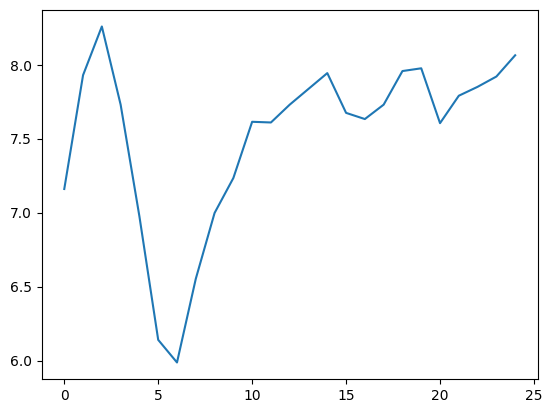

In [52]:
plt.plot(lambdai)

### Simulation

In [71]:
from order_book import OrderBook

In [94]:

N = 1000
price_ticks = np.linspace(-100, 100, 2001)
ob = OrderBook(max_depth=100)
sizes = np.zeros(1000)
sizes[0] = 1
asks = {price: size for price, size in zip(price_ticks[1000:], sizes)}

sizes = np.zeros(1000)
sizes[-1] = 1
bids = {price: size for price, size in zip(price_ticks[:1000], sizes)}


ob['asks'] = asks
ob['bids'] = bids

    

In [ ]:
for i in range(N):
    ...

In [96]:
thetai

array([69.39717017, 40.00264675, 15.49707498,  7.0029401 ,  5.22554309,
        5.38410609,  7.00201454,  9.3224364 , 10.88801863, 11.34831183,
       11.28925282, 10.03360913,  8.08308986,  7.36975345,  7.05179461,
        7.46520686,  7.20969011,  6.09162633,  5.9932021 ,  7.11043344,
        8.33628114,  9.48409689, 12.57232844, 11.92181766, 12.12596961])

In [97]:
Sc

-91339.22140752267

In [98]:
Sl

91185.42959216148

In [92]:
ob.bids[-0.15] = 2

In [93]:
ob.bids.to_dict()

{-0.09999999999999432: 1.0,
 -0.15: 2,
 -0.19999999999998863: 0.0,
 -0.29999999999999716: 0.0,
 -0.3999999999999915: 0.0,
 -0.5: 0.0,
 -0.5999999999999943: 0.0,
 -0.6999999999999886: 0.0,
 -0.7999999999999972: 0.0,
 -0.8999999999999915: 0.0,
 -1.0: 0.0,
 -1.0999999999999943: 0.0,
 -1.1999999999999886: 0.0,
 -1.2999999999999972: 0.0,
 -1.3999999999999915: 0.0,
 -1.5: 0.0,
 -1.5999999999999943: 0.0,
 -1.6999999999999886: 0.0,
 -1.7999999999999972: 0.0,
 -1.8999999999999915: 0.0,
 -2.0: 0.0,
 -2.0999999999999943: 0.0,
 -2.1999999999999886: 0.0,
 -2.299999999999997: 0.0,
 -2.3999999999999915: 0.0,
 -2.5: 0.0,
 -2.5999999999999943: 0.0,
 -2.6999999999999886: 0.0,
 -2.799999999999997: 0.0,
 -2.8999999999999915: 0.0,
 -3.0: 0.0,
 -3.0999999999999943: 0.0,
 -3.1999999999999886: 0.0,
 -3.299999999999997: 0.0,
 -3.3999999999999915: 0.0,
 -3.5: 0.0,
 -3.5999999999999943: 0.0,
 -3.6999999999999886: 0.0,
 -3.799999999999997: 0.0,
 -3.8999999999999915: 0.0,
 -4.0: 0.0,
 -4.099999999999994: 0.0,
 -4.

In [53]:
r['mid'] = 1/2*(r['ASK0'] + r['BID0'])

In [54]:
(r['mid'].diff() > 0).mean()

0.35823529411764704

In [16]:
import json
import numpy as np
from typing import Optional
from scipy.stats import binom
from tqdm.notebook import tqdm
from order_book import OrderBook
from abc import abstractmethod, ABC


class MyOrderBook(OrderBook):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

    def spread(self) -> float:
        assert len(self.bids) > 0 and len(self.asks) > 0
        return self.asks.index(0)[0] - self.bids.index(0)[0]

    def __repr__(self) -> str:
        ob = {k: self.to_dict()[k] for k in sorted(self.to_dict())}
        return json.dumps(ob, indent=4)

    def vbbid(self) -> float:
        return self.bids.index(0)[-1]

    def vbask(self) -> float:
        return self.asks.index(0)[-1]

    def increment_vbask(self) -> None:
        price, vol = self.asks.index(0)
        self.asks[price] = vol + 1

    def decrement_vbask(self) -> None:
        price, vol = self.asks.index(0)

        if vol == 1:
            del self.asks[price]
        else:
            self.asks[price] = vol - 1

    def decrement_vbbid(self) -> None:
        price, vol = self.bids.index(0)

        if vol == 1:
            del self.bids[price]
        else:
            self.bids[price] = vol - 1

    def increment_vbbid(self) -> None:
        price, vol = self.bids.index(0)
        self.bids[price] = vol + 1


class MonteCarloExperiment(ABC):
    def __init__(self, trials=10_000, verbose=False, **params) -> None:
        self.verbose = verbose
        self.trials = trials
        self.params = params

    @abstractmethod
    def reset_state(self) -> None:
        ...

    @abstractmethod
    def update_state(self) -> None:
        ...

    @abstractmethod
    def success(self) -> Optional[bool]:
        """
        Is used to detemine desirable outcome, once the conditional events are
        reached. For example: in midprice increase probability, success() must
        be called, once midprice is changing and its change is positive. In all
        other cases, it must return nothing

        Returns:
            bool (optional): whether conditional is reached and outcome is
        a desirable function returns True. Otherwise - None.
        """
        ...

    @abstractmethod
    def failure(self) -> Optional[bool]:
        """
        is used to determine events, which are recorgnised as failures
        of the monte-carlo experiment. They are important, because those events
        determine conditionals. For example: when we want to calculate the
        probability of the mid price increase, we do it conditional on the
        midprice change. In other words, we calculate probability of the next
        midprice change being positive. In that scenario, failure() function
        must return true, if midprice changed in the opposite direction.
        Otherwise, experiment must continue, until next mid price change occurs

        Returns:
            bool (optional): whether conditional is reached and the outcome is
        a undesirable. In all other cases function returns None.
        """
        ...

    def evaluate(self) -> float:
        count = 0
        trials = range(self.trials)
        trials = tqdm(trials) if self.verbose else trials

        for trial in trials:
            self.reset_state()

            while True:
                self.update_state()

                if self.success():
                    count += 1
                    break

                elif self.failure():
                    break

        return count / self.trials


class BidOrderExecution(MonteCarloExperiment):
    def __init__(self, bbid_orders=5, bask_orders=5,
                 bid_pos=5, trials=10000, verbose=False, **params) -> None:
        super().__init__(trials, verbose, **params)

        self.bbid_orders = bbid_orders
        self.bask_orders = bask_orders
        self.bid_pos = bid_pos
        self.reset_state()

    def reset_state(self) -> None:
        self.xb = self.bbid_orders
        self.xa = self.bask_orders
        self.bid_idx = self.bid_pos

    def success(self) -> Optional[bool]:
        if self.bid_idx == 0:
            return True

    def failure(self) -> Optional[bool]:
        if self.xa == 0:
            return True

    def update_state(self) -> None:
        # since our orders are never canceled
        xb_rate = self.xb - 1
        xs_rate = self.xa

        if self.bid_idx == 0:
            xb_rate = self.xb

        lamda, mu = self.params['lamda'], self.params['mu']
        theta = self.params['theta']

        cum_rate = 2*mu + 2*lamda + theta*xb_rate + theta*xs_rate

        pevent = np.array([
            lamda,            # limit bid +1
            lamda,            # limit ask +1
            mu,               # bought market bid
            mu,               # bought market ask
            theta * xb_rate,  # cancel bid -1
            theta * xs_rate   # cancel ask -1
        ]) / cum_rate

        event = np.random.choice(np.arange(6), size=1, p=pevent)[0]

        if event == 0:
            self.xb += 1

        elif event == 1:
            self.xa += 1

        elif event == 2:
            self.xb -= 1
            # position moves in queue
            self.bid_idx -= 1 if self.bid_idx > 0 else 0

        elif event == 3:
            self.xa -= 1

        # cancellations
        elif event == 4:
            if np.random.uniform() > (self.xb - self.bid_idx) / xb_rate:
                # cancellation before our price
                self.bid_idx -= 1
            self.xb -= 1

        elif event == 5:
            self.xa -= 1


class MakingSpread(MonteCarloExperiment):
    def __init__(self, bbid_orders=5, bask_orders=5,
                 bid_pos=5, ask_pos=5, trials=10_000, verbose=False, **params):
        super().__init__(trials, verbose, **params)

        self.bbid_orders = bbid_orders
        self.bask_orders = bask_orders
        self.bid_pos = bid_pos
        self.ask_pos = ask_pos
        self.reset_state()

    def reset_state(self) -> None:
        self.xb = self.bbid_orders
        self.xa = self.bask_orders
        self.bid_idx = self.bid_pos
        self.ask_idx = self.ask_pos

    def update_state(self) -> None:
        # since our orders are never canceled

        lamda, mu = self.params['lamda'], self.params['mu']
        theta = self.params['theta']

        xb_rate = self.xb - 1
        xa_rate = self.xa - 1

        if self.bid_idx == 0:
            xb_rate = self.xb

        if self.ask_idx == 0:
            xa_rate = self.xa

        cum_rate = 2*mu + 2*lamda + theta*xb_rate + theta*xa_rate

        pevent = np.array([
            lamda,            # limit bid +1
            lamda,            # limit ask +1
            mu,               # bought market bid
            mu,               # bought market ask
            theta * xb_rate,  # cancel bid -1
            theta * xa_rate   # cancel ask -1
        ]) / cum_rate

        event = np.random.choice(np.arange(6), size=1, p=pevent)[0]

        if event == 0:
            self.xb += 1

        elif event == 1:
            self.xa += 1

        elif event == 2:
            self.xb -= 1
            # position moves in queue
            self.bid_idx -= 1 if self.bid_idx > 0 else 0

        elif event == 3:
            self.xa -= 1
            # position moves in queue
            self.ask_idx -= 1 if self.ask_idx > 0 else 0

        # cancellations
        elif event == 4:
            if np.random.uniform() > (self.xb - self.bid_idx) / xb_rate:
                # cancellation before our price
                self.bid_idx -= 1
            self.xb -= 1

        elif event == 5:
            if np.random.uniform() > (self.xa - self.ask_idx) / xa_rate:
                # cancellation before our price
                self.ask_idx -= 1
            self.xa -= 1

    def failure(self) -> Optional[bool]:

        # if midprice goes down
        if self.xb == 0 and self.ask_idx > 0:
            return True

        # if midprice goes up
        elif self.xa == 0 and self.bid_idx > 0:
            return True

    def success(self) -> Optional[bool]:
        # if both our orders have executed
        if self.bid_idx == 0 and self.ask_idx == 0:
            return True


class MidpriceUp(MonteCarloExperiment):
    def __init__(self, bbid_orders: int = 5, bask_orders: int = 5,
                 spread: int = 10, trials: int = 10000, verbose=False,
                 **params):
        super().__init__(trials, verbose, **params)

        self.bbid_orders = bbid_orders
        self.bask_orders = bask_orders
        self.spread = spread
        self.reset_state()

    def reset_state(self) -> None:
        self.xb = self.bbid_orders
        self.xa = self.bask_orders
        self.S = self.spread

        self.ob = MyOrderBook()
        self.ob.asks[self.spread] = self.bask_orders
        self.ob.bids[0] = self.bbid_orders

    def success(self) -> Optional[bool]:
        """
        Nescessary condition: midprice changes
        Desirable outcome:    midprice increases
        """
        if len(self.ob.bids) > 1 or len(self.ob.asks) == 0:
            return True

    def failure(self) -> Optional[bool]:
        """
        Nescessary condition: midprice changes
        Undesirable outcome:  midprice drops
        """

        # midprice decreases, if new asks get within spread
        # or when best bid level is exhausted
        if len(self.ob.asks) > 1 or len(self.ob.bids) == 0:
            return True

    def update_state(self) -> None:

        lamda, mu = self.params['lamda'], self.params['mu']
        theta, lambda_ = self.params['theta'], self.params['lambda_']

        birth_inspread_ask = np.array([lambda_(i) for i in range(1, self.S)])
        birth_inspread_bid = np.array([lambda_(i) for i in range(1, self.S)])

        birth_bid = lamda
        birth_ask = lamda
        death_bid = mu + theta*self.ob.vbbid()
        death_ask = mu + theta*self.ob.vbask()

        pevent = np.array([birth_bid, birth_ask, death_bid, death_ask])
        pevent = np.append(pevent, birth_inspread_ask)
        pevent = np.append(pevent, birth_inspread_bid)
        pevent /= pevent.sum()

        event = np.random.choice(np.arange(len(pevent)), size=1, p=pevent)[0]

        if event == 0:
            self.ob.increment_vbbid()

        elif event == 1:
            self.ob.increment_vbask()

        elif event == 2:
            self.ob.decrement_vbbid()

        elif event == 3:
            self.ob.decrement_vbask()

        elif event >= 4 and event < 4 + self.S:
            inspread_dist = event - 3
            # price of best ask
            new_bask = self.ob.asks.index(0)[0] - inspread_dist
            self.ob.asks[new_bask] = 1

        elif event >= 4 + self.S:

            inspread_dist = event - 3 - self.S
            # price of best bid
            new_bbid = self.ob.bids.index(0)[0] + inspread_dist
            self.ob.bids[new_bbid] = 1


class MakingSpreadS(MonteCarloExperiment):
    def __init__(self, bbid_orders: int = 5, bask_orders: int = 5,
                 bid_pos: int = 5, ask_pos: int = 5, spread: int = 1,
                 trials: int = 10_000, verbose=False, **params):
        super().__init__(trials, verbose, **params)

        self.bbid_orders = bbid_orders
        self.bask_orders = bask_orders
        self.bid_pos = bid_pos
        self.ask_pos = ask_pos
        self.spread = spread
        self.reset_state()

    def reset_state(self) -> None:
        self.xb = self.bbid_orders
        self.xa = self.bask_orders
        self.S = self.spread
        self.bid_idx = self.bid_pos
        self.ask_idx = self.ask_pos

        self.ob = MyOrderBook()
        self.ob.asks[self.spread] = self.bask_orders
        self.ob.bids[0] = self.bbid_orders

    def update_state(self) -> None:

        lamda, mu = self.params['lamda'], self.params['mu']
        theta, lambda_ = self.params['theta'], self.params['lambda_']

        birth_inspread_ask = np.array([lambda_(i) for i in range(1, self.S)])
        birth_inspread_bid = np.array([lambda_(i) for i in range(1, self.S)])

        # since our orders are never canceled
        xb_rate = self.ob.vbbid() - 1
        xa_rate = self.ob.vbask() - 1

        if self.bid_idx == 0:
            xb_rate = self.ob.vbbid()

        if self.ask_idx == 0:
            xa_rate = self.ob.vbask()

        birth_bid = lamda
        birth_ask = lamda
        market_buy = mu
        market_sell = mu
        death_bid = theta*xb_rate
        death_ask = theta*xa_rate

        pevent = np.array([
            birth_bid,
            birth_ask,
            market_buy,
            market_sell,
            death_bid,
            death_ask
        ])
        pevent = np.append(pevent, birth_inspread_ask)
        pevent = np.append(pevent, birth_inspread_bid)
        pevent /= pevent.sum()

        event = np.random.choice(np.arange(len(pevent)), size=1, p=pevent)[0]

        # new bid order at best bid price
        if event == 0:
            self.ob.increment_vbbid()

        # new ask order at best ask price
        elif event == 1:
            self.ob.increment_vbask()

        # market sell at the best bid price
        elif event == 2:
            self.ob.decrement_vbbid()
            # our position moves in the queue
            self.bid_idx -= 1 if self.bid_idx > 0 else 0

        # market buy at the best ask price
        elif event == 3:
            self.ob.decrement_vbask()
            # our position moves in the queue
            self.ask_idx -= 1 if self.ask_idx > 0 else 0

        # cancellation of bid
        elif event == 4:
            r = np.random.uniform()
            if r > (self.ob.vbbid() - self.bid_idx) / xb_rate:
                # cancellation before our price
                self.bid_idx -= 1

            self.ob.decrement_vbbid()

        # cancellation of ask
        elif event == 5:
            r = np.random.uniform()
            if r > (self.ob.vbask() - self.ask_idx) / xa_rate:
                # cancellation before our price
                self.ask_idx -= 1

            self.ob.decrement_vbask()

        # inspread ask arrivals
        elif event >= 6 and event < 6 + self.S:
            inspread_dist = event - 5
            # price of best ask
            new_bask = self.ob.asks.index(0)[0] - inspread_dist
            self.ob.asks[new_bask] = 1

        # inspread bid arrivals
        elif event >= 6 + self.S:
            inspread_dist = event - 5 - self.S
            # price of best bid
            new_bbid = self.ob.bids.index(0)[0] + inspread_dist
            self.ob.bids[new_bbid] = 1

    def failure(self) -> Optional[bool]:
        """
        Nescessary condition: midprice changes
        Undesirable outcome:  any of the orders are not fulfilled
        """

        # if new bid/ask appears within spread
        if len(self.ob.bids) > 1 or len(self.ob.asks) > 1:
            if self.ask_idx != 0 or self.bid_idx != 0:
                return True

        # if midprice goes up, but we didnt close positions
        if len(self.ob.asks) == 0 and self.bid_idx > 0:
            return True

        # if midprice goes down, but we didnt close positions
        elif len(self.ob.bids) == 0 and self.ask_idx > 0:
            return True

    def success(self) -> Optional[bool]:
        """
        Nescessary condition: midprice changes
        Desirable outcome:    both orders are fulfilled
        """
        # we earn if both ask and bid orders are fulfilled
        # but at the same time, midprice doesnt change

        if self.bid_idx == 0 and self.ask_idx == 0:
            return True


class StopLossReaching(MidpriceUp):
    """
    Probability of reaching stop loss corresponds to the probability of
    midprice moving certain amount of ticks away.
    """

    def __init__(self, n_times: int, k_ticks: int,
                 bbid_orders: int = 5, bask_orders: int = 5,
                 spread: int = 10, trials: int = 10000,
                 verbose=False, **params):
        super().__init__(bbid_orders, bask_orders, spread,
                         trials, verbose, **params)

        self.n_times = n_times
        self.k_ticks = k_ticks

    def evaluate(self) -> float:
        p = 1 - super().evaluate()
        k = self.k_ticks
        summed = 0
        for j in range(1, self.trials):
            n = k + 2 * j
            summed += binom.pmf(k=(n - k) / 2, n=n, p=p)

        return summed


In [22]:
def get_lambda(idx: int, lambdas: pd.Series):
    return lambdas[min(idx, len(lambdas) - 1)]


def get_theta(idx: int, thetas: pd.Series):
    return thetas[min(idx, len(thetas) - 1)]

In [21]:
get_lambda(30, lambdai)

8.06356906578548

In [35]:
thetai

array([69.39717017, 40.00264675, 15.49707498,  7.0029401 ,  5.22554309,
        5.38410609,  7.00201454,  9.3224364 , 10.88801863, 11.34831183,
       11.28925282, 10.03360913,  8.08308986,  7.36975345,  7.05179461,
        7.46520686,  7.20969011,  6.09162633,  5.9932021 ,  7.11043344,
        8.33628114,  9.48409689, 12.57232844, 11.92181766, 12.12596961])

In [36]:
binance_params = {
    'lamda': get_lambda(0, lambdai),
    'mu': mu,
    'theta': 5.38410609,
    'lambda_': lambda x: get_lambda(x, lambdai)
}


In [46]:
r

,side,size,price,BID0,BID1,BID2,BID3,BID4,BID5,BID6,BID7,BID8,BID9,BID10,BID11,BID12,BID13,BID14,BID15,BID16,BID17,BID18,BID19,BID20,BID21,BID22,BID23,BID24,ASK0,ASK1,ASK2,ASK3,ASK4,ASK5,ASK6,ASK7,ASK8,ASK9,ASK10,ASK11,ASK12,ASK13,ASK14,ASK15,ASK16,ASK17,ASK18,ASK19,ASK20,ASK21,ASK22,ASK23,ASK24,VASK0,VASK1,VASK2,VASK3,VASK4,VASK5,VASK6,VASK7,VASK8,VASK9,VASK10,VASK11,VASK12,VASK13,VASK14,VASK15,VASK16,VASK17,VASK18,VASK19,VASK20,VASK21,VASK22,VASK23,VASK24,VBID0,VBID1,VBID2,VBID3,VBID4,VBID5,VBID6,VBID7,VBID8,VBID9,VBID10,VBID11,VBID12,VBID13,VBID14,VBID15,VBID16,VBID17,VBID18,VBID19,VBID20,VBID21,VBID22,VBID23,VBID24,counter,mid
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-04-04 23:32:16.821988096,sell,3.015,310.86,310.84,310.70,310.69,310.57,310.54,310.49,310.40,310.39,310.34,310.32,310.31,310.22,310.10,310.00,309.80,309.66,309.63,309.60,309.58,309.53,309.52,309.50,309.27,309.20,309.14,310.86,310.90,310.93,310.94,310.95,311.04,311.14,311.17,311.20,311.22,311.47,311.49,311.50,311.61,311.76,311.77,312.00,312.36,312.37,312.40,312.44,312.50,312.68,312.75,312.77,2.985,4.884,2.622,9.900,398.571,13.000,10.000,10.000,10.000,88.588,88.922,129.261,100.000,85.621,13.775000,432.927847,20.739000,3.270,1.951,264.906,3.479,8.671,2.706,0.324,0.456,13.000,2.982,9.900,2.709,483.945,88.588,0.647,10.000,88.922,129.261,1.953,3.482,85.621,132.662,12.744,436.183,3.273,32.176,0.389,0.326,2.709,0.600,1.953,263.045,0.981,1,310.850
2023-04-04 23:32:18.942563328,NaN,NaN,NaN,310.73,310.72,310.71,310.70,310.57,310.54,310.49,310.40,310.39,310.34,310.32,310.31,310.22,310.10,310.00,309.80,309.66,309.63,309.60,309.58,309.53,309.52,309.50,309.27,309.20,310.86,310.89,310.90,310.94,310.95,311.04,311.14,311.17,311.20,311.22,311.47,311.49,311.50,311.61,311.76,311.77,312.00,312.36,312.37,312.40,312.44,312.50,312.68,312.75,312.77,2.985,7.346,4.884,9.900,398.571,13.000,10.000,10.000,10.000,88.588,88.922,129.261,100.000,85.621,13.775000,432.927847,20.739000,3.270,1.951,264.906,3.479,8.671,2.706,0.324,0.456,13.000,14.394,13.000,2.982,2.709,483.945,88.588,0.647,10.000,88.922,129.261,1.953,3.482,85.621,132.662,12.744,436.183,3.273,32.176,0.389,0.326,2.709,0.600,1.953,263.045,1,310.795
2023-04-04 23:32:20.942411776,buy,1.088,310.81,310.80,310.79,310.78,310.77,310.57,310.54,310.49,310.40,310.39,310.34,310.32,310.31,310.22,310.10,310.00,309.80,309.66,309.63,309.60,309.58,309.53,309.52,309.50,309.27,309.20,310.86,310.89,310.90,310.93,310.94,310.95,311.04,311.14,311.17,311.20,311.22,311.47,311.49,311.50,311.61,311.76,311.77,312.00,312.36,312.37,312.40,312.44,312.50,312.68,312.75,2.985,0.912,4.884,1.773,9.900,398.571,13.000,10.000,10.000,10.000,88.588,88.922,129.261,100.000,85.621000,13.775000,432.927847,20.739,3.270,1.951,264.906,3.479,8.671,2.706,0.324,4.494,13.000,7.884,13.000,2.709,483.945,88.588,0.647,10.000,88.922,129.261,1.953,3.482,85.621,132.662,12.744,436.183,3.273,32.176,0.389,0.326,2.709,0.600,1.953,263.045,2,310.830
2023-04-04 23:32:21.942597632,NaN,NaN,NaN,310.83,310.81,310.80,310.58,310.57,310.54,310.49,310.40,310.39,310.34,310.32,310.31,310.22,310.10,310.00,309.80,309.66,309.63,309.60,309.58,309.53,309.52,309.50,309.27,309.20,310.86,310.89,310.90,310.93,310.94,310.95,311.04,311.14,311.17,311.20,311.22,311.47,311.49,311.50,311.61,311.76,311.77,312.00,312.36,312.37,312.40,312.44,312.50,312.68,312.75,2.985,0.912,4.884,1.618,9.900,398.571,13.000,10.000,10.000,10.000,88.588,88.922,129.261,100.000,85.621000,13.775000,432.927847,20.739,3.270,1.951,264.906,3.479,8.671,2.706,0.324,13.000,13.000,4.494,7.884,2.709,483.945,88.588,0.647,10.000,88.922,129.261,1.953,3.482,85.621,132.662,12.744,436.183,3.273,32.176,0.389,0.326,2.709,0.600,1.953,263.045,2,310.845
2023-04-04 23:32:22.942608640,NaN,NaN,NaN,310.83,310.80,310.58,310.57,310.54,310.49,310.40,310.34,310.32,310.31,310.22,310.10,310.00,309.80,309.66,309.63,309.60,309.58,309.53,309.52,309.50,309.27,309.20,309.14,309.11,310.86,310.89,310.90,310.9

In [ ]:
MidpriceUp()

In [37]:
from itertools import product

# MidpriceUp()

def simulate_grid(max_ask, max_bid, max_spread, params):

    sizes = list(product(range(1, max_bid), range(1, max_ask)))
    mid_price_probs = []
    for spread in tqdm(range(1, max_spread + 1)):
        probs = []
        for bid_size, ask_size in sizes:
            m = MidpriceUp(
                bid_size,
                ask_size,
                trials=1000,
                **params
            ).evaluate()
            
            probs.append(m)

        mid_price_probs.append(probs)
    return mid_price_probs
        
        
binance_grid = simulate_grid(6, 6, 10, binance_params)


  0%|          | 0/10 [00:00<?, ?it/s]

In [38]:
binance_params['theta']

5.38410609

In [39]:
pd.DataFrame(binance_grid)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,0.446,0.416,0.411,0.425,0.416,0.464,0.458,0.446,0.445,0.448,0.466,0.440,0.425,0.424,0.401,0.441,0.445,0.429,0.430,0.446,0.463,0.425,0.456,0.436,0.446
1,0.430,0.413,0.428,0.428,0.413,0.470,0.429,0.470,0.442,0.428,0.461,0.436,0.422,0.438,0.445,0.443,0.464,0.420,0.466,0.444,0.450,0.446,0.450,0.447,0.419
2,0.423,0.419,0.430,0.418,0.439,0.449,0.438,0.421,0.443,0.454,0.458,0.434,0.410,0.423,0.437,0.438,0.464,0.434,0.415,0.452,0.463,0.451,0.442,0.434,0.444
3,0.440,0.441,0.432,0.437,0.427,0.462,0.431,0.437,0.423,0.427,0.480,0.455,0.437,0.430,0.455,0.472,0.451,0.450,0.478,0.472,0.428,0.437,0.427,0.444,0.440
4,0.436,0.396,0.454,0.400,0.409,0.462,0.433,0.448,0.439,0.420,0.468,0.453,0.437,0.440,0.448,0.435,0.459,0.443,0.435,0.457,0.464,0.440,0.421,0.446,0.447
5,0.407,0.421,0.416,0.431,0.421,0.440,0.443,0.427,0.438,0.443,0.440,0.450,0.407,0.449,0.429,0.430,0.428,0.440,0.460,0.431,0.475,0.447,0.445,0.435,0.438
6,0.432,0.409,0.429,0.439,0.428,0.443,0.469,0.448,0.427,0.444,0.464,0.436,0.466,0.450,0.445,0.458,0.435,0.436,0.430,0.431,0.465,0.424,0.482,0.429,0.406
7,0.443,0.444,0.412,0.434,0.413,0.451,0.432,0.416,0.457,0.459,0.457,0.424,0.430,0.467,0.427,0.440,0.454,0.470,0.450,0.429,0.447,0.410,0.417,0.399,0.463
8,0.443,0.425,0.403,0.414,0.425,0.462,0.408,0.436,0.440,0.469,0.452,0.461,0.457,0.418,0.432,0.467,0.439,0.421,0.442,0.427,0.469,0.452,0.444,0.436,0.461
9,0.449,0.420,0.401,0.463,0.425,0.465,0.445,0.416,0.447,0.402,0.448,0.437,0.428,0.447,0.422,0.470,0.453,0.415,0.441,0.430,0.459,0.418,0.422,0.438,0.439


In [100]:
r

,side,size,price,BID0,BID1,BID2,BID3,BID4,BID5,BID6,BID7,BID8,BID9,BID10,BID11,BID12,BID13,BID14,BID15,BID16,BID17,BID18,BID19,BID20,BID21,BID22,BID23,BID24,ASK0,ASK1,ASK2,ASK3,ASK4,ASK5,ASK6,ASK7,ASK8,ASK9,ASK10,ASK11,ASK12,ASK13,ASK14,ASK15,ASK16,ASK17,ASK18,ASK19,ASK20,ASK21,ASK22,ASK23,ASK24,VASK0,VASK1,VASK2,VASK3,VASK4,VASK5,VASK6,VASK7,VASK8,VASK9,VASK10,VASK11,VASK12,VASK13,VASK14,VASK15,VASK16,VASK17,VASK18,VASK19,VASK20,VASK21,VASK22,VASK23,VASK24,VBID0,VBID1,VBID2,VBID3,VBID4,VBID5,VBID6,VBID7,VBID8,VBID9,VBID10,VBID11,VBID12,VBID13,VBID14,VBID15,VBID16,VBID17,VBID18,VBID19,VBID20,VBID21,VBID22,VBID23,VBID24,counter,mid
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-04-04 23:32:16.821988096,sell,3015.0,310.86,310.84,310.70,310.69,310.57,310.54,310.49,310.40,310.39,310.34,310.32,310.31,310.22,310.10,310.00,309.80,309.66,309.63,309.60,309.58,309.53,309.52,309.50,309.27,309.20,309.14,310.86,310.90,310.93,310.94,310.95,311.04,311.14,311.17,311.20,311.22,311.47,311.49,311.50,311.61,311.76,311.77,312.00,312.36,312.37,312.40,312.44,312.50,312.68,312.75,312.77,2985.0,4884.0,2622.0,9900.0,398571.0,13000.0,10000.0,10000.0,10000.0,88588.0,88922.0,129261.0,100000.0,85621.0,13775.000000,432927.846938,20739.000000,3270.0,1951.0,264906.0,3479.0,8671.0,2706.0,324.0,456.0,13000.0,2982.0,9900.0,2709.0,483945.0,88588.0,647.0,10000.0,88922.0,129261.0,1953.0,3482.0,85621.0,132662.0,12744.0,436183.0,3273.0,32176.0,389.0,326.0,2709.0,600.0,1953.0,263045.0,981.0,1,310.850
2023-04-04 23:32:18.942563328,NaN,NaN,NaN,310.73,310.72,310.71,310.70,310.57,310.54,310.49,310.40,310.39,310.34,310.32,310.31,310.22,310.10,310.00,309.80,309.66,309.63,309.60,309.58,309.53,309.52,309.50,309.27,309.20,310.86,310.89,310.90,310.94,310.95,311.04,311.14,311.17,311.20,311.22,311.47,311.49,311.50,311.61,311.76,311.77,312.00,312.36,312.37,312.40,312.44,312.50,312.68,312.75,312.77,2985.0,7346.0,4884.0,9900.0,398571.0,13000.0,10000.0,10000.0,10000.0,88588.0,88922.0,129261.0,100000.0,85621.0,13775.000000,432927.846938,20739.000000,3270.0,1951.0,264906.0,3479.0,8671.0,2706.0,324.0,456.0,13000.0,14394.0,13000.0,2982.0,2709.0,483945.0,88588.0,647.0,10000.0,88922.0,129261.0,1953.0,3482.0,85621.0,132662.0,12744.0,436183.0,3273.0,32176.0,389.0,326.0,2709.0,600.0,1953.0,263045.0,1,310.795
2023-04-04 23:32:20.942411776,buy,1088.0,310.81,310.80,310.79,310.78,310.77,310.57,310.54,310.49,310.40,310.39,310.34,310.32,310.31,310.22,310.10,310.00,309.80,309.66,309.63,309.60,309.58,309.53,309.52,309.50,309.27,309.20,310.86,310.89,310.90,310.93,310.94,310.95,311.04,311.14,311.17,311.20,311.22,311.47,311.49,311.50,311.61,311.76,311.77,312.00,312.36,312.37,312.40,312.44,312.50,312.68,312.75,2985.0,912.0,4884.0,1773.0,9900.0,398571.0,13000.0,10000.0,10000.0,10000.0,88588.0,88922.0,129261.0,100000.0,85621.000000,13775.000000,432927.846938,20739.0,3270.0,1951.0,264906.0,3479.0,8671.0,2706.0,324.0,4494.0,13000.0,7884.0,13000.0,2709.0,483945.0,88588.0,647.0,10000.0,88922.0,129261.0,1953.0,3482.0,85621.0,132662.0,12744.0,436183.0,3273.0,32176.0,389.0,326.0,2709.0,600.0,1953.0,263045.0,2,310.830
2023-04-04 23:32:21.942597632,NaN,NaN,NaN,310.83,310.81,310.80,310.58,310.57,310.54,310.49,310.40,310.39,310.34,310.32,310.31,310.22,310.10,310.00,309.80,309.66,309.63,309.60,309.58,309.53,309.52,309.50,309.27,309.20,310.86,310.89,310.90,310.93,310.94,310.95,311.04,311.14,311.17,311.20,311.22,311.47,311.49,311.50,311.61,311.76,311.77,312.00,312.36,312.37,312.40,312.44,312.50,312.68,312.75,2985.0,912.0,4884.0,1618.0,9900.0,398571.0,13000.0,10000.0,10000.0,10000.0,88588.0,88922.0,129261.0,100000.0,85621.000000,13775.000000,432927.846938,20739.0,3270.0,1951.0,264906.0,3479.0,8671.0,2706.0,324.0,13000.0,13000.0,4494.0,7884.0,2709.0,483945.0,88588.0,647.0,10000.0,88922.0,129261.0,1953.0,3482.0,85621.0,132662.0,12744.0,436183.0,3273.0,32176.0,389.0,326.0,2709.0,600.0,1953.0,263045.0,2,310.845
2023-04-04 23:32:22.942608640,NaN,NaN,NaN,

In [103]:
r

,side,size,price,BID0,BID1,BID2,BID3,BID4,BID5,BID6,BID7,BID8,BID9,BID10,BID11,BID12,BID13,BID14,BID15,BID16,BID17,BID18,BID19,BID20,BID21,BID22,BID23,BID24,ASK0,ASK1,ASK2,ASK3,ASK4,ASK5,ASK6,ASK7,ASK8,ASK9,ASK10,ASK11,ASK12,ASK13,ASK14,ASK15,ASK16,ASK17,ASK18,ASK19,ASK20,ASK21,ASK22,ASK23,ASK24,VASK0,VASK1,VASK2,VASK3,VASK4,VASK5,VASK6,VASK7,VASK8,VASK9,VASK10,VASK11,VASK12,VASK13,VASK14,VASK15,VASK16,VASK17,VASK18,VASK19,VASK20,VASK21,VASK22,VASK23,VASK24,VBID0,VBID1,VBID2,VBID3,VBID4,VBID5,VBID6,VBID7,VBID8,VBID9,VBID10,VBID11,VBID12,VBID13,VBID14,VBID15,VBID16,VBID17,VBID18,VBID19,VBID20,VBID21,VBID22,VBID23,VBID24,counter,mid
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-04-04 23:32:16.821988096,sell,3015.0,310.86,310.84,310.70,310.69,310.57,310.54,310.49,310.40,310.39,310.34,310.32,310.31,310.22,310.10,310.00,309.80,309.66,309.63,309.60,309.58,309.53,309.52,309.50,309.27,309.20,309.14,310.86,310.90,310.93,310.94,310.95,311.04,311.14,311.17,311.20,311.22,311.47,311.49,311.50,311.61,311.76,311.77,312.00,312.36,312.37,312.40,312.44,312.50,312.68,312.75,312.77,2985.0,4884.0,2622.0,9900.0,398571.0,13000.0,10000.0,10000.0,10000.0,88588.0,88922.0,129261.0,100000.0,85621.0,13775.000000,432927.846938,20739.000000,3270.0,1951.0,264906.0,3479.0,8671.0,2706.0,324.0,456.0,13000.0,2982.0,9900.0,2709.0,483945.0,88588.0,647.0,10000.0,88922.0,129261.0,1953.0,3482.0,85621.0,132662.0,12744.0,436183.0,3273.0,32176.0,389.0,326.0,2709.0,600.0,1953.0,263045.0,981.0,1,310.850
2023-04-04 23:32:18.942563328,NaN,NaN,NaN,310.73,310.72,310.71,310.70,310.57,310.54,310.49,310.40,310.39,310.34,310.32,310.31,310.22,310.10,310.00,309.80,309.66,309.63,309.60,309.58,309.53,309.52,309.50,309.27,309.20,310.86,310.89,310.90,310.94,310.95,311.04,311.14,311.17,311.20,311.22,311.47,311.49,311.50,311.61,311.76,311.77,312.00,312.36,312.37,312.40,312.44,312.50,312.68,312.75,312.77,2985.0,7346.0,4884.0,9900.0,398571.0,13000.0,10000.0,10000.0,10000.0,88588.0,88922.0,129261.0,100000.0,85621.0,13775.000000,432927.846938,20739.000000,3270.0,1951.0,264906.0,3479.0,8671.0,2706.0,324.0,456.0,13000.0,14394.0,13000.0,2982.0,2709.0,483945.0,88588.0,647.0,10000.0,88922.0,129261.0,1953.0,3482.0,85621.0,132662.0,12744.0,436183.0,3273.0,32176.0,389.0,326.0,2709.0,600.0,1953.0,263045.0,1,310.795
2023-04-04 23:32:20.942411776,buy,1088.0,310.81,310.80,310.79,310.78,310.77,310.57,310.54,310.49,310.40,310.39,310.34,310.32,310.31,310.22,310.10,310.00,309.80,309.66,309.63,309.60,309.58,309.53,309.52,309.50,309.27,309.20,310.86,310.89,310.90,310.93,310.94,310.95,311.04,311.14,311.17,311.20,311.22,311.47,311.49,311.50,311.61,311.76,311.77,312.00,312.36,312.37,312.40,312.44,312.50,312.68,312.75,2985.0,912.0,4884.0,1773.0,9900.0,398571.0,13000.0,10000.0,10000.0,10000.0,88588.0,88922.0,129261.0,100000.0,85621.000000,13775.000000,432927.846938,20739.0,3270.0,1951.0,264906.0,3479.0,8671.0,2706.0,324.0,4494.0,13000.0,7884.0,13000.0,2709.0,483945.0,88588.0,647.0,10000.0,88922.0,129261.0,1953.0,3482.0,85621.0,132662.0,12744.0,436183.0,3273.0,32176.0,389.0,326.0,2709.0,600.0,1953.0,263045.0,2,310.830
2023-04-04 23:32:21.942597632,NaN,NaN,NaN,310.83,310.81,310.80,310.58,310.57,310.54,310.49,310.40,310.39,310.34,310.32,310.31,310.22,310.10,310.00,309.80,309.66,309.63,309.60,309.58,309.53,309.52,309.50,309.27,309.20,310.86,310.89,310.90,310.93,310.94,310.95,311.04,311.14,311.17,311.20,311.22,311.47,311.49,311.50,311.61,311.76,311.77,312.00,312.36,312.37,312.40,312.44,312.50,312.68,312.75,2985.0,912.0,4884.0,1618.0,9900.0,398571.0,13000.0,10000.0,10000.0,10000.0,88588.0,88922.0,129261.0,100000.0,85621.000000,13775.000000,432927.846938,20739.0,3270.0,1951.0,264906.0,3479.0,8671.0,2706.0,324.0,13000.0,13000.0,4494.0,7884.0,2709.0,483945.0,88588.0,647.0,10000.0,88922.0,129261.0,1953.0,3482.0,85621.0,132662.0,12744.0,436183.0,3273.0,32176.0,389.0,326.0,2709.0,600.0,1953.0,263045.0,2,310.845
2023-04-04 23:32:22.942608640,NaN,NaN,NaN,

In [118]:
min_prices[EXCHANGE][SYMBOL]

0.01

In [123]:
price_grid = np.linspace(200, 400, num=20001)
sizes_grid = np.zeros(shape=20001)
price_grid

array([200.  , 200.01, 200.02, ..., 399.98, 399.99, 400.  ])

In [125]:
sizes_grid

array([0., 0., 0., ..., 0., 0., 0.])

In [127]:
thetai

array([69.39717017, 40.00264675, 15.49707498,  7.0029401 ,  5.22554309,
        5.38410609,  7.00201454,  9.3224364 , 10.88801863, 11.34831183,
       11.28925282, 10.03360913,  8.08308986,  7.36975345,  7.05179461,
        7.46520686,  7.20969011,  6.09162633,  5.9932021 ,  7.11043344,
        8.33628114,  9.48409689, 12.57232844, 11.92181766, 12.12596961])

In [122]:
for i in range(1000)

,VASK0,VASK1,VASK2,VASK3,VASK4,VASK5,VASK6,VASK7,VASK8,VASK9,VASK10,VASK11,VASK12,VASK13,VASK14,VASK15,VASK16,VASK17,VASK18,VASK19,VASK20,VASK21,VASK22,VASK23,VASK24
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,
2023-04-04 23:32:16.821988096,2985.0,4884.0,2622.0,9900.0,398571.0,13000.0,10000.0,10000.0,10000.0,88588.0,88922.0,129261.0,100000.0,85621.0,13775.000000,432927.846938,20739.000000,3270.0,1951.0,264906.0,3479.0,8671.0,2706.0,324.0,456.0
2023-04-04 23:32:18.942563328,2985.0,7346.0,4884.0,9900.0,398571.0,13000.0,10000.0,10000.0,10000.0,88588.0,88922.0,129261.0,100000.0,85621.0,13775.000000,432927.846938,20739.000000,3270.0,1951.0,264906.0,3479.0,8671.0,2706.0,324.0,456.0
2023-04-04 23:32:20.942411776,2985.0,912.0,4884.0,1773.0,9900.0,398571.0,13000.0,10000.0,10000.0,10000.0,88588.0,88922.0,129261.0,100000.0,85621.000000,13775.000000,432927.846938,20739.0,3270.0,1951.0,264906.0,3479.0,8671.0,2706.0,324.0
2023-04-04 23:32:21.942597632,2985.0,912.0,4884.0,1618.0,9900.0,398571.0,13000.0,10000.0,10000.0,10000.0,88588.0,88922.0,129261.0,100000.0,85621.000000,13775.000000,432927.846938,20739.0,3270.0,1951.0,264906.0,3479.0,8671.0,2706.0,324.0
2023-04-04 23:32:22.942608640,2985.0,912.0,4884.0,4627.0,398571.0,13000.0,10000.0,10000.0,88588.0,88922.0,129261.0,100000.0,85621.0,13775.0,432927.846938,20739.000000,3270.000000,1951.0,264906.0,3479.0,8671.0,2706.0,324.0,456.0,423.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-05 03:07:41.942413056,6995.0,4884.0,8014.0,98588.0,10000.0,10000.0,129261.0,100000.0,3270.0,88922.0,1951.0,85621.0,422.0,642.0,9493.000000,3479.000000,13775.000000,432813.0,267612.0,1758.0,1038.0,210535.0,643.0,3270.0,327.0
2023-04-05 03:08:00.942814976,6995.0,4048.0,4884.0,98588.0,10000.0,10000.0,129261.0,100000.0,3270.0,88922.0,1951.0,85621.0,422.0,642.0,9493.000000,3479.000000,13775.000000,432813.0,267612.0,1758.0,1038.0,210535.0,643.0,3270.0,327.0
2023-04-05 03:08:01.942478080,13000.0,4884.0,13000.0,8014.0,98588.0,10000.0,10000.0,129261.0,100000.0,3270.0,88922.0,1951.0,85621.0,422.0,642.000000,9493.000000,3479.000000,13775.0,432813.0,267612.0,1758.0,1038.0,210535.0,643.0,3270.0


In [117]:
min_sizes[EXCHANGE][SYMBOL]

0.0001

In [113]:
r[r['counter'] == 2][asks]

,ASK0,ASK1,ASK2,ASK3,ASK4,ASK5,ASK6,ASK7,ASK8,ASK9,ASK10,ASK11,ASK12,ASK13,ASK14,ASK15,ASK16,ASK17,ASK18,ASK19,ASK20,ASK21,ASK22,ASK23,ASK24
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,
2023-04-04 23:32:20.942411776,310.86,310.89,310.90,310.93,310.94,310.95,311.04,311.14,311.17,311.20,311.22,311.47,311.49,311.50,311.61,311.76,311.77,312.00,312.36,312.37,312.40,312.44,312.50,312.68,312.75
2023-04-04 23:32:21.942597632,310.86,310.89,310.90,310.93,310.94,310.95,311.04,311.14,311.17,311.20,311.22,311.47,311.49,311.50,311.61,311.76,311.77,312.00,312.36,312.37,312.40,312.44,312.50,312.68,312.75
2023-04-04 23:32:22.942608640,310.86,310.89,310.90,310.94,310.95,311.04,311.17,311.20,311.22,311.47,311.49,311.50,311.61,311.76,311.77,312.00,312.36,312.37,312.40,312.44,312.50,312.68,312.75,312.77,312.85
2023-04-04 23:32:23.942538496,310.86,310.89,310.90,310.94,310.95,311.04,311.17,311.20,311.22,311.47,311.49,311.50,311.61,311.76,311.77,312.00,312.36,312.37,312.40,312.44,312.50,312.68,312.75,312.77,312.85
2023-04-04 23:32:24.942749440,310.86,310.90,310.95,311.04,311.17,311.20,311.22,311.47,311.49,311.50,311.61,311.76,311.77,312.00,312.36,312.37,312.40,312.44,312.50,312.68,312.75,312.77,312.85,312.87,313.00
2023-04-04 23:32:25.942265600,310.86,310.88,310.90,310.94,310.95,311.04,311.17,311.20,311.22,311.47,311.49,311.50,311.61,311.76,311.77,312.00,312.36,312.37,312.40,312.44,312.50,312.68,312.75,312.77,312.85
2023-04-04 23:32:26.942993408,310.86,310.90,310.94,310.95,311.04,311.17,311.20,311.22,311.47,311.49,311.50,311.61,311.76,311.77,312.00,312.36,312.37,312.40,312.44,312.50,312.68,312.75,312.77,312.85,312.87


In [109]:
r[r['counter'] == 2][vasks].diff()

,VASK0,VASK1,VASK2,VASK3,VASK4,VASK5,VASK6,VASK7,VASK8,VASK9,VASK10,VASK11,VASK12,VASK13,VASK14,VASK15,VASK16,VASK17,VASK18,VASK19,VASK20,VASK21,VASK22,VASK23,VASK24
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,
2023-04-04 23:32:20.942411776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-04 23:32:21.942597632,0.0,0.0,0.0,-155.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-04-04 23:32:22.942608640,0.0,0.0,0.0,3009.0,388671.0,-385571.0,-3000.0,0.0,78588.0,78922.0,40673.0,11078.0,-43640.000000,-86225.000000,347306.846938,6964.0,-429657.846938,-18788.0,261636.0,1528.0,-256235.0,-773.0,-8347.0,-2250.0,99.0
2023-04-04 23:32:23.942538496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-04-04 23:32:24.942749440,0.0,3972.0,393687.0,8373.0,-388571.0,-3000.0,78588.0,78922.0,40673.0,11078.0,-43640.0,-86225.0,347306.846938,6964.000000,-429657.846938,-18788.0,261636.000000,1528.0,-256235.0,-773.0,-8347.0,-2250.0,99.0,-68.0,5253.0
2023-04-04 23:32:25.942265600,0.0,-3972.0,-393687.0,-3831.0,398471.0,3000.0,-78588.0,-78922.0,-40673.0,-11078.0,43640.0,86225.0,-347306.846938,-6964.000000,429657.846938,18788.0,-261636.000000,-1528.0,256235.0,773.0,8347.0,2250.0,-99.0,68.0,-5253.0
2023-04-04 23:32:26.942993408,0.0,3972.0,4285.0,399302.0,-395471.0,-3000.0,0.0,78588.0,334.0,40339.0,-29261.0,-14379.0,-71846.000000,419152.846938,-412188.846938,-17469.0,-1319.000000,262955.0,-261427.0,5192.0,-5965.0,-2382.0,132.0,-33.0,-35.0


In [101]:
v_diff = r[vbids + vasks].diff().dropna()
v_diff_no_shifts = v_diff[(v_diff == 0).any(axis=1)]

In [102]:
v_diff_no_shifts

,VBID0,VBID1,VBID2,VBID3,VBID4,VBID5,VBID6,VBID7,VBID8,VBID9,VBID10,VBID11,VBID12,VBID13,VBID14,VBID15,VBID16,VBID17,VBID18,VBID19,VBID20,VBID21,VBID22,VBID23,VBID24,VASK0,VASK1,VASK2,VASK3,VASK4,VASK5,VASK6,VASK7,VASK8,VASK9,VASK10,VASK11,VASK12,VASK13,VASK14,VASK15,VASK16,VASK17,VASK18,VASK19,VASK20,VASK21,VASK22,VASK23,VASK24
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-04-04 23:32:18.942563328,0.0,11412.0,3100.0,273.0,-481236.0,395357.0,87941.0,-9353.0,-78922.0,-40339.0,127308.0,-1529.0,-82139.0,-47041.0,119918.0,-423439.0,432910.0,-28903.0,31787.0,63.0,-2383.0,2109.0,-1353.0,-261092.0,262064.0,0.0,2462.0,2262.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-04-04 23:32:20.942411776,-8506.0,-1394.0,-5116.0,10018.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6434.0,0.0,-8127.0,-388671.0,385571.0,3000.0,0.0,0.0,-78588.0,-334.0,-40339.0,29261.0,14379.0,71846.000000,-419152.846938,412188.846938,17469.0,1319.0,-262955.0,261427.0,-5192.0,5965.0,2382.0,-132.0
2023-04-04 23:32:21.942597632,8506.0,0.0,-3390.0,-5116.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-155.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-04-04 23:32:22.942608640,0.0,-8506.0,3390.0,-5175.0,481236.0,-395357.0,-87941.0,88275.0,119261.0,-86969.0,-125779.0,83668.0,129180.0,-72877.0,303521.0,-9471.0,-404007.0,-2884.0,-31850.0,2320.0,274.0,-756.0,262445.0,-972.0,-259563.0,0.0,0.0,0.0,3009.0,388671.0,-385571.0,-3000.0,0.0,78588.0,78922.0,40673.0,11078.0,-43640.0,-86225.0,347306.846938,6964.000000,-429657.846938,-18788.0,261636.0,1528.0,-256235.0,-773.0,-8347.0,-2250.0,99.0
2023-04-04 23:32:23.942538496,0.0,0.0,5116.0,5175.0,-481236.0,395357.0,87941.0,-88275.0,-40339.0,127308.0,8471.0,-82139.0,-47041.0,119918.0,-423439.0,432910.0,-28903.0,31787.0,63.0,-2383.0,2109.0,-1353.0,-261092.0,262064.0,-2501.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-05 03:07:41.942413056,217.0,2925.0,0.0,84564.0,-3000.0,-78588.0,119261.0,0.0,-40339.0,-9611.0,11078.0,64157.0,-14379.0,-61837.0,349913.0,28004.0,-432052.0,-28760.0,-209.0,29961.0,259772.0,-31270.0,-176730.0,356.0,-83606.0,5825.0,-8116.0,3130.0,90574.0,-88588.0,0.0,119261.0,-29261.0,-96730.0,85652.0,-86971.0,83670.0,-85199.0,220.0,8851.000000,-6014.000000,10296.000000,419038.0,-165201.0,-265854.0,-720.0,209497.0,-209892.0,2627.0,-2943.0
2023-04-05 03:08:00.942814976,0.0,0.0,75588.0,-78588.0,119261.0,0.0,-40339.0,-9611.0,11078.0,64157.0,-14379.0,-61837.0,349913.0,28004.0,-432052.0,-28760.0,-209.0,29961.0,259772.0,-31270.0,-176730.0,356.0,-83606.0,2273.0,-756.0,0.0,-836.0,-3130.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-04-05 03:08:01.942478080,-217.0,0.0,-78513.0,78588.0,-119261.0,119261.0,-78922.0,88533.0,-99611.0,35454.0,-21075.0,82912.0,-432825.0,404821.0,27231.0,1529.0,-1320.0,-28641.0,-231131.0,262401.0,-85671.0,85315.0,-1709.0,-564.0,1320.0,6005.0,836.0,8116.0,-90574.0,88588.0,0.0,-119261.0,29261.0,96730.0,-85652.0,86971.0,-83670.0,85199.0,-220.0,-8851.000000,6014.000000,-10296.000000,-419038.0,165201.0,265854.0,720.0,-209497.0,209892.0,-2627.0,2943.0
